Name: Antony Krymski

Username: agk-123

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_gbm(start_price, mu, sigma, n_steps, dt):
    prices = [start_price]
    for _ in range(n_steps):
        prices.append(prices[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal()))
    return np.array(prices)

# Parameters
start_price = 100
mu = 0.0002  # Drift coefficient
sigma = 0.01  # Volatility coefficient
n_steps = 1000
dt = 1  # Time step

# Generate GBM prices
gbm_prices = generate_gbm(start_price, mu, sigma, n_steps, dt)

# Plot the generated prices
plt.figure(figsize=(14, 7))
plt.plot(gbm_prices)
plt.title('Geometric Brownian Motion - Simulated Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()


In [5]:
def generate_random_walk(start_price, n_steps):
    returns = np.random.normal(0, 1, n_steps)
    prices = start_price + np.cumsum(returns)
    return prices

# Parameters
start_price = 100
n_steps = 1_000_000

# Generate random walk
random_walk_prices = generate_random_walk(start_price, n_steps)

# Plot the generated prices
plt.figure(figsize=(14, 7))
plt.plot(random_walk_prices)
plt.title('Random Walk - Simulated Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [40]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Layer, Conv2D, Dropout, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import keras

# Data

In [18]:
df = pd.read_hdf('data/data.h5', 'SPY')
df.index = pd.to_datetime(df.index, unit='s')
df = np.rint(df * 100).astype(np.int32)
df

,Open,High,Low,Close,Volume
Date,,,,,
1998-07-01 09:32:00,738100,738100,737700,737700,25760000
1998-07-01 09:33:00,738400,738600,738100,738100,2440000
1998-07-01 09:34:00,738100,738600,738100,738600,250000
1998-07-01 09:35:00,738300,738300,737900,737900,90000
1998-07-01 09:36:00,738300,738300,738100,738100,300000
...,...,...,...,...,...
2023-03-31 15:55:00,4087600,4093400,4087400,4091800,156284100
2023-03-31 15:56:00,4091900,4093400,4090500,4093200,70754400
2023-03-31 15:57:00,4093300,4094100,4092400,4094000,80362600


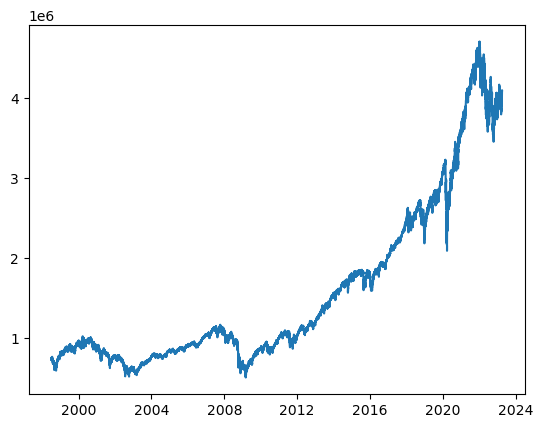

In [19]:
plt.plot(df['Close'])

# Pre-processing

(2399384, 1)


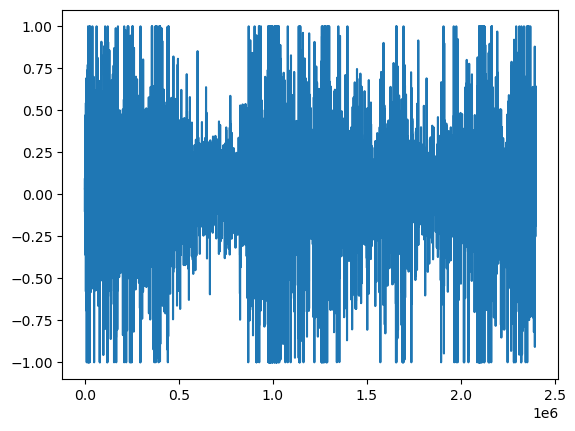

In [20]:
# select features
X = df[['Close']].values 
X = X.astype(np.float32)

# make data stationary using log returns
X = np.log(X)
X = np.diff(X, axis=0)

# remove 0.01% outliers
outliers = np.quantile(np.abs(X), 0.9999)
X = np.clip(X, -outliers, outliers)

# scale
X = X / np.max(np.abs(X))

assert(np.isnan(X).any() == False)

plt.plot(X[:, 0])
print(X.shape)

In [21]:
timesteps = 128
features = 1
batch_size = 16
steps = 1
length = len(X) - timesteps - steps
train_index = int(0.8 * length)

x_train = X[:train_index]
x_test = X[train_index:]

y_train = x_train[timesteps::timesteps]
y_test = x_test[timesteps::timesteps]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1919404, 1) (479980, 1)
(14995, 1) (3749, 1)


In [22]:
# window data
def window(data, timesteps, strides=1):
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def scale(data):
    # min-max scaling
    return (data - np.min(data)) / (np.max(data) - np.min(data))

x_train = window(x_train, timesteps, timesteps)
x_test = window(x_test, timesteps, timesteps)

print(x_train.shape, x_test.shape)

assert(x_train.shape[0] == y_train.shape[0])

(14995, 128, 1) (3749, 128, 1)


# Data Generation

In [23]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.timesteps = timesteps
        self.data = data
        # self.data = self.window(data, timesteps, strides)
        self.indexes = np.arange(len(self.data) - 1)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    # def window(self, data, timesteps, strides=1):
    #     x = []
    #     for i in range(0, len(data) - timesteps, strides):
    #         x.append(data[i:i+timesteps])
    #     return np.array(x)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.data[idx]
            y_positive = self.data[idx+1]
            
            # base case
            # y_negative = np.zeros_like(y_positive)
            
            # flipping but not well (only do if non stationary data)
            # y_negative = np.max(y_positive) + np.min(y_positive) - y_positive
            
            # make y_negative normal distribution from same range as y_positive
            y_negative = np.random.normal(np.mean(x_positive), np.std(x_positive), x_positive.shape[0])
            y_negative = np.clip(y_negative, -1.0, 1.0)
            y_negative = np.expand_dims(y_negative, -1)
            
            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        labels = np.expand_dims(np.array(labels), axis=-1)
        return (np.array(x), np.array(y)), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [24]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(x, y), labels = dg.__getitem__(0)
print(f"x shape: {x.shape}, y shape: {y.shape}, labels shape: {labels.shape}")

937
x shape: (16, 128, 1), y shape: (16, 128, 1), labels shape: (16, 1)


# Inspecting Windows

In [25]:
def window_plot(a, x, y, labels):
    plt.figure(figsize=(20, 4))
    
    # Plot the first window x[a]
    plt.subplot(1, 3, 1)
    plt.plot(x[a, :, 0], label='x[{}]'.format(a))
    plt.legend()
    plt.title(f'First Window x[{a}]')
    
    # Plot the corresponding y[a] with label
    plt.subplot(1, 3, 2)
    plt.plot(y[a, :, 0], label=f'y[{a}]: {bool(labels[a])}')
    plt.legend()
    plt.title(f'Corresponding y[{a}] with label {bool(labels[a])}')
    
    # Plot another window x[a+2] and corresponding y[a+2]
    plt.subplot(1, 3, 3)
    plt.plot(x[a+2, :, 0], label='x[{}]'.format(a+2))
    plt.plot(y[a, :, 0], label=f'y[{a}]: {bool(labels[a])}')
    plt.legend()
    plt.title(f'Window x[{a+2}] and Corresponding y[{a}]')

    plt.show()

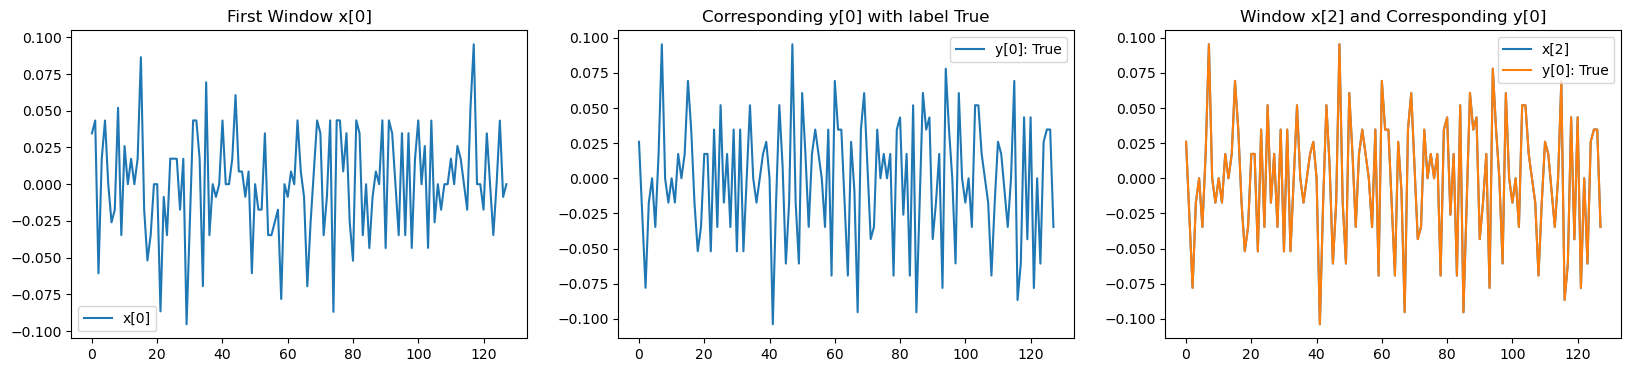

In [26]:
window_plot(0, x, y, labels)

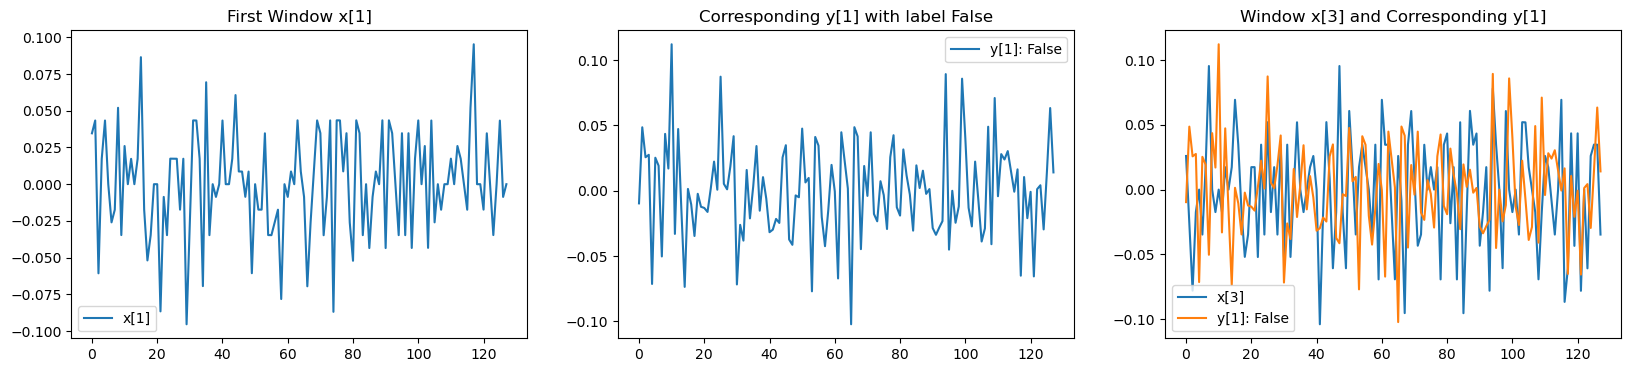

In [27]:
window_plot(1, x, y, labels)

# Model Architecture

In [28]:
def network_encoder(x, code_size):
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Dense(256, activation='linear')(x)
    x = Dense(128, activation='linear')(x)
    x = Flatten()(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    # x = Reshape((-1,1))(x)
    return x

In [137]:
code_size = 32
input_shape = (timesteps, features)

encoder_input = Input(input_shape)
encoder_output = network_encoder(encoder_input, code_size)
encoder_model = Model(encoder_input, encoder_output, name='encoder')
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 64)           256       
                                                                 
 dense_13 (Dense)            (None, 128, 128)          8320      
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 encoder_embedding (Dense)   (None, 32)                524320    
                                                                 
Total params: 532,896
Trainable params: 532,896
Non-trainable params: 0
_________________________________________________________________


In [138]:
x_input = Input(input_shape)
x_encoded = encoder_model(x_input)

# integrates information along the sequence
x_encoded = (Reshape((-1,1))(x_encoded))
# context = GRU(256, return_sequences=False, name="context")(x_encoded)
context = LSTM(256, return_sequences=False, name="context")(x_encoded)

# predict z-latent from context
preds = Dense(code_size, activation="linear", name="preds")(context)

y_input = Input(input_shape)
y_encoded = encoder_model(y_input)

dot_product = K.sum(y_encoded * preds, axis=-1)
# dot_product = K.batch_dot(y_encoded, preds, axes=1)
dot_product = K.sigmoid(dot_product)

model = Model(inputs=[x_input, y_input], outputs=dot_product, name='contrastive')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "contrastive"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 128, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 32)           532896      ['input_16[0][0]',               
                                                                  'input_17[0][0]']               
                                                                                                  
 reshape_8 (Reshape)            (None, 32, 1)        0           ['encoder[0][0]']      

In [139]:
from tensorflow.keras.callbacks import Callback

class SaveBestEncoderCallback(Callback):
    def __init__(self, encoder_model, filepath):
        super(SaveBestEncoderCallback, self).__init__()
        self.encoder_model = encoder_model
        self.filepath = filepath
        self.best = 0

    def on_epoch_end(self, epoch, logs=None):
        # Print logs for debugging purposes
        if logs is not None:
            print(f'Logs for epoch {epoch + 1}: {logs}')

        current = logs.get('val_binary_accuracy')  # Use the correct key for validation accuracy
        if current is None:
            return
        
        if current > self.best:
            self.best = current
            self.encoder_model.save(self.filepath)
            print(f'\nEpoch {epoch + 1}: Saving encoder model weights to {self.filepath}')


In [140]:
from tensorflow.keras.callbacks import ModelCheckpoint
batch_size = 64
epochs = 50

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

# Define the file path to save the best encoder weights
encoder_weights_path = 'best_encoder_weights.h5'

# Create the SaveBestEncoderCallback
save_best_encoder_callback = SaveBestEncoderCallback(
    encoder_model=encoder_model,
    filepath=encoder_weights_path
)

history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen, callbacks=[save_best_encoder_callback])

Epoch 1/50
234/234 [==============================] - ETA: 0s - loss: 0.6830 - binary_accuracy: 0.5686Logs for epoch 1: {'loss': 0.6830303072929382, 'binary_accuracy': 0.5686431527137756, 'val_loss': 0.685835063457489, 'val_binary_accuracy': 0.556034505367279}

Epoch 1: Saving encoder model weights to best_encoder_weights.h5
234/234 [==============================] - 14s 56ms/step - loss: 0.6830 - binary_accuracy: 0.5686 - val_loss: 0.6858 - val_binary_accuracy: 0.5560
Epoch 2/50
234/234 [==============================] - 14s 58ms/step - loss: 0.6602 - binary_accuracy: 0.6127 - val_loss: 0.6845 - val_binary_accuracy: 0.5560
Epoch 3/50
233/234 [============================>.] - ETA: 0s - loss: 0.5974 - binary_accuracy: 0.6803Logs for epoch 3: {'loss': 0.5971092581748962, 'binary_accuracy': 0.6805555820465088, 'val_loss': 0.6341413855552673, 'val_binary_accuracy': 0.6799569129943848}

Epoch 3: Saving encoder model weights to best_encoder_weights.h5
234/234 [==============================

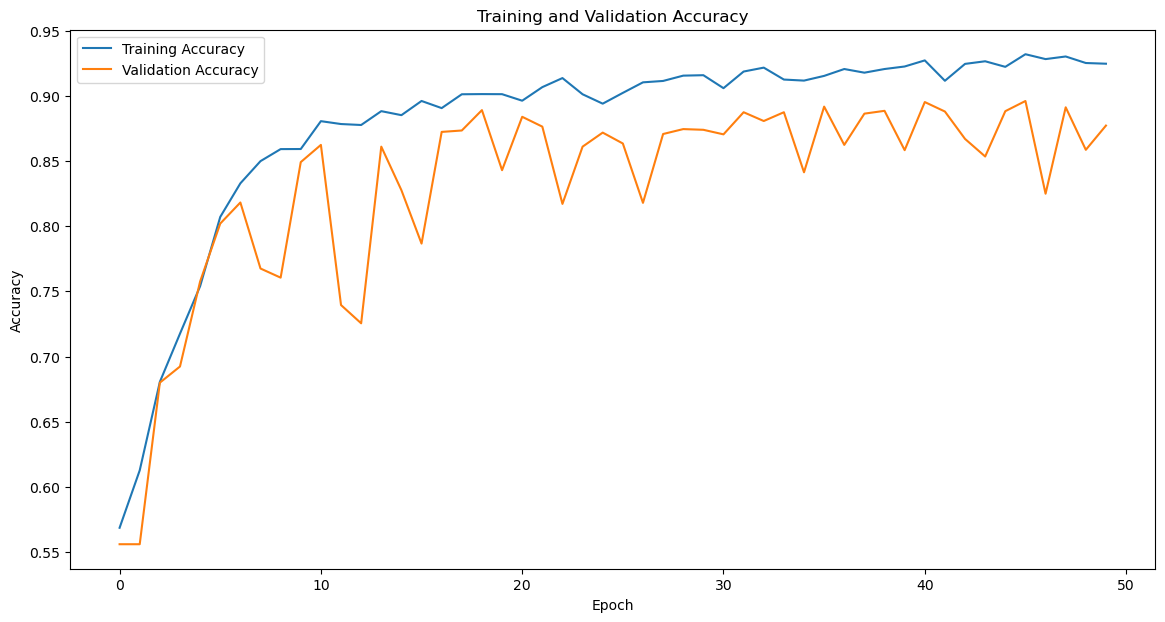

In [142]:
# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [143]:
# encoder_model.save('encoder_30_07_lstm.h5', include_optimizer=False)

In [41]:
from keras.regularizers import l2

In [42]:
code_size = 32

In [43]:
features = 1
input_shape = (timesteps, features)

In [50]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(128, 3, activation='relu', padding='same')(input)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((timesteps, features), code_size)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 128, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 128, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 128, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_embedding (Dense)       │ (None, 128, 32)        │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,200 (403.12 KB)

 Trainable params: 103,200 (403.12 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, name="context")(input)
    x = BatchNormalization()(x)
    x = LSTM(128, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

Model: "context"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ context (LSTM)                  │ (None, 128, 128)       │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 128, 32)        │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,168 (856.12 KB)

 Trainable params: 218,656 (854.12 KB)

 Non-trainable params: 512 (2.00 KB)

In [52]:
# test classification naively 
# x_input = Input(input_shape, name='x_input')
# y_input = Input(input_shape, name='y_input')

# x = keras.layers.Concatenate(axis=1)([x_input, y_input])
# # x = y_input
# x = Conv1D(32, 3, activation='relu', padding='same')(x)
# x = LSTM(32, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=[x_input, y_input], outputs=x, name='CPC')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
# model.summary()

In [53]:
x_input = Input(input_shape)
encoded = encoder(x_input)
y_pred = context(encoded)

y_input = Input(input_shape)
y_encoded = encoder(y_input)

# dot_product = K.sum(y_encoded * y_pred, axis=-1)
# # dot_product = K.mean(y_encoded * y_pred, axis=-1)
# dot_product = K.mean(dot_product, axis=-1, keepdims=True)  # along the temporal dimension

# dot_product = K.sigmoid(dot_product)

# model = Model(inputs=[x_input, y_input], outputs=dot_product, name='CPC')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
# model.summary()

class DotProductLayer(Layer):
    def __init__(self, **kwargs):
        super(DotProductLayer, self).__init__(**kwargs)

    def call(self, inputs):
        y_encoded, y_pred = inputs
        dot_product = tf.reduce_sum(y_encoded * y_pred, axis=-1)
        dot_product = tf.reduce_mean(dot_product, axis=-1, keepdims=True)  # along the temporal dimension
        return tf.sigmoid(dot_product)

# Use the custom layer in your model
dot_product = DotProductLayer()([y_encoded, y_pred])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model = Model(inputs=[x_input, y_input], outputs=dot_product, name='CPC')
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["binary_accuracy"])
model.summary()

Model: "CPC"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 128, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 128, 32)   │    103,200 │ input_layer_14[0… │
│ (Functional)        │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context             │ (None, 128, 32)   │    219,168 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product_layer_1 │ (None, 1)         │          0 │ encoder[1][0],    │
│ (DotProductLayer)   │                   │            │ context[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 322,368 (1.23 MB)

 Trainable params: 321,856 (1.23 MB)

 Non-trainable params: 512 (2.00 KB)

In [54]:
batch_size = 256
epochs = 40

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=False)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=False)

In [55]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - binary_accuracy: 0.5461 - loss: 0.6894 - val_binary_accuracy: 0.5329 - val_loss: 0.6927
Epoch 2/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - binary_accuracy: 0.5645 - loss: 0.6764 - val_binary_accuracy: 0.5368 - val_loss: 0.6931
Epoch 3/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - binary_accuracy: 0.5885 - loss: 0.6697 - val_binary_accuracy: 0.5215 - val_loss: 0.6950
Epoch 4/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - binary_accuracy: 0.5978 - loss: 0.6658 - val_binary_accuracy: 0.5114 - val_loss: 0.7022
Epoch 5/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - binary_accuracy: 0.6263 - loss: 0.6546 - val_binary_accuracy: 0.5223 - val_loss: 0.7299
Epoch 6/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - binary_accuracy: 0.6755 - loss: 0.6405 - val_binary_accuracy: 0.5257 - val_loss: 0.7821
Epoch 7/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - binary_accuracy: 0.6885 - loss: 0.6239 - val_binary_accuracy: 0.5566 - val_loss: 0.9291
Epoch

KeyboardInterrupt: 

# Downstream Task

### Balance dataset

In [ ]:
y_test = np.where(y_test > 0, 1., 0)
y_train = np.where(y_train > 0, 1., 0)

In [ ]:
# Separate the classes using boolean indexing
zeros_mask = y_test == 0
ones_mask = y_test == 1

y_zeros = y_test[zeros_mask]
y_ones = y_test[ones_mask]

# Determine the size of the minority class
minority_class_size = min(len(y_zeros), len(y_ones))

# Sequential undersampling
y_undersampled_zeros = y_zeros[:minority_class_size]

# Combine the undersampled majority class with the minority class
y_balanced = np.hstack((y_undersampled_zeros, y_ones))

# Sort by the original order to maintain the time series sequence
sorted_indices = np.argsort(np.hstack((np.where(zeros_mask)[0][:minority_class_size], np.where(ones_mask)[0])))
y_balanced = y_balanced[sorted_indices]

# Verify the balance
unique, counts = np.unique(y_balanced, return_counts=True)
balanced_class_counts = dict(zip(unique, counts))
print(balanced_class_counts)

{0.0: 1782, 1.0: 1782}


(3564, 128, 1) (3564,)


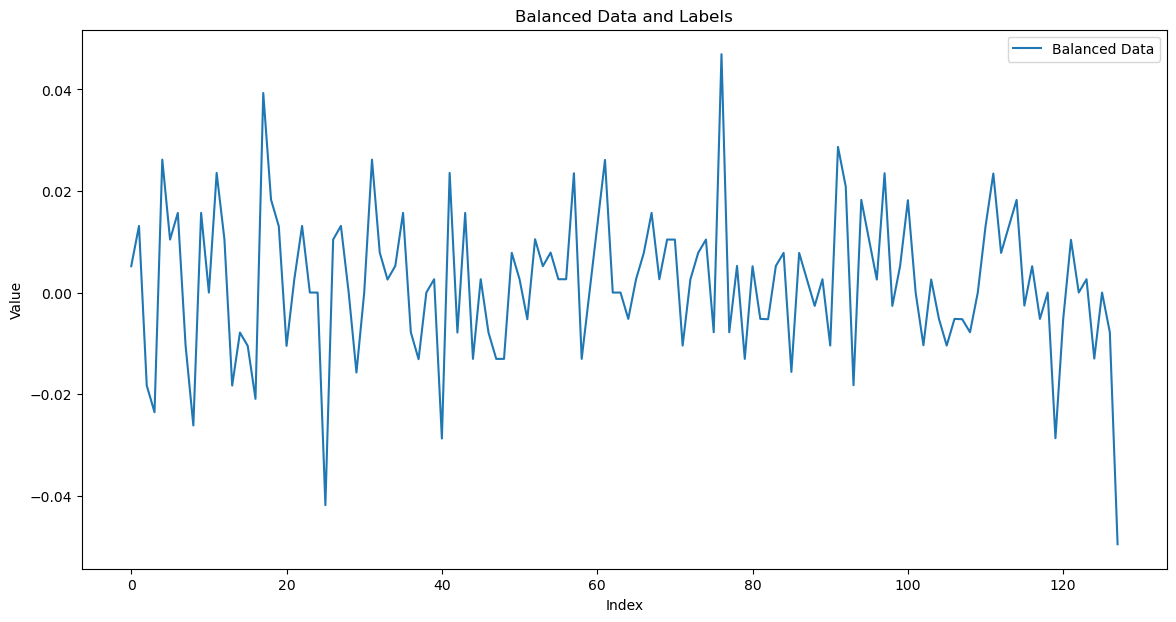

In [ ]:
# Balance x_data and y_data
x_test_balanced = x_test[sorted_indices]
y_test_balanced = y_balanced

# Print the shapes of the balanced datasets
print(x_test_balanced.shape, y_test_balanced.shape)

# plot the balanced data of x and y
plt.figure(figsize=(14, 7))
plt.plot(x_test_balanced[0, :], label='Balanced Data')
# plt.plot(y_test_balanced, label='Balanced Labels')
plt.title('Balanced Data and Labels')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# encoder_model = load_model('encoder_30_07_lstm.h5', compile=True)
encoder_model = load_model('best_encoder_weights.h5', compile=True)
encoder_model.trainable = False  # Freeze the encoder model

x_input = Input(input_shape)
x = encoder_model(x_input)
# x = Reshape((-1, 1))(x)
# x = GRU(256, return_sequences=False)(x)
# x = LSTM(512, return_sequences=False, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

forecasting_model = Model(x_input, x)
# forecasting_model.compile(optimizer='adam', loss='mse')
forecasting_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
forecasting_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 128, 1)]          0         
                                                                 
 encoder (Functional)        (None, 32)                532896    
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 535,041
Trainable params: 2,145
Non-trainable params: 532,896
_________________________________________________________________


In [ ]:
# # round positive values to +1 and negative to -1 
# y_train = np.where(y_train > 0, 1., 0)
# y_test = np.where(y_test > 0, 1., 0)

In [ ]:
# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_ds.h5',
    monitor='val_binary_accuracy',  # Monitor validation accuracy
    mode='max',  # Save the model when validation accuracy improves
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when saving the model
)

## With Encoder

In [ ]:
history = forecasting_model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_test_balanced, y_test_balanced), callbacks=[checkpoint_callback])

Epoch 1/20
230/235 [============================>.] - ETA: 0s - loss: 0.7103 - binary_accuracy: 0.5594
Epoch 1: val_binary_accuracy improved from -inf to 0.49327, saving model to best_model_ds.h5
235/235 [==============================] - 1s 4ms/step - loss: 0.7098 - binary_accuracy: 0.5599 - val_loss: 0.7237 - val_binary_accuracy: 0.4933
Epoch 2/20
223/235 [===========================>..] - ETA: 0s - loss: 0.6929 - binary_accuracy: 0.5682
Epoch 2: val_binary_accuracy improved from 0.49327 to 0.50224, saving model to best_model_ds.h5
235/235 [==============================] - 1s 4ms/step - loss: 0.6923 - binary_accuracy: 0.5683 - val_loss: 0.7045 - val_binary_accuracy: 0.5022
Epoch 3/20
231/235 [============================>.] - ETA: 0s - loss: 0.6893 - binary_accuracy: 0.5699
Epoch 3: val_binary_accuracy improved from 0.50224 to 0.50281, saving model to best_model_ds.h5
235/235 [==============================] - 1s 3ms/step - loss: 0.6892 - binary_accuracy: 0.5703 - val_loss: 0.7084 -

KeyboardInterrupt: 

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## RL Downstream Task

In [196]:
# Define the feature extraction using the encoder
def extract_features(encoder_model, data):
    return encoder_model.predict(data)

# Load the pre-trained encoder model
encoder_model = load_model('best_encoder_weights.h5', custom_objects={'network_encoder': network_encoder})

# Define your Sharpe Ratio function
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

def positions(x, theta):
    num_windows = len(x)
    num_features = len(x[0])  # Number of features per window
    Ft = np.zeros(num_windows)
    for t in range(len(theta) - 2, num_windows):
        xt = np.concatenate([[1], x[t - len(theta) + 2], [Ft[t - 1]]])  # Include the bias term and previous position
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

# Define the returns function
def returns(Ft, x, delta):
    num_windows = len(x)
    rets = Ft[0:num_windows - 1] * x[1:num_windows] - delta * np.abs(Ft[1:num_windows] - Ft[0:num_windows - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    num_windows = len(x)
    num_features = len(x[0])  # Number of features per window

    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / num_windows
    dBdR = 2. / num_windows * R
    
    grad = np.zeros(len(theta))  # initialize gradient
    dFpdtheta = np.zeros(len(theta))  # for storing previous dFdtheta
    
    for t in range(len(theta) - 2, num_windows):
        xt = np.concatenate([[1], x[t - len(theta) + 2], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

    return grad, S

def train(x, epochs=2000, num_features=32, delta=0.0025, learning_rate=0.3):
    theta = np.random.rand(num_features + 2)  # +2 for the constant term and previous position
    sharpes = np.zeros(epochs)  # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, delta)
        theta = theta + grad * learning_rate
        sharpes[i] = sharpe
    print("finished training")
    return theta, sharpes



In [197]:
x_train_features = extract_features(encoder_model, x_train)
x_test_features = extract_features(encoder_model, x_test)
print("x_train_features shape:", x_train_features.shape)
print("x_test_features shape:", x_test_features.shape)


118/118 [==============================] - 0s 1ms/step
x_train_features shape: (14995, 32)
x_test_features shape: (3749, 32)


In [198]:
# Train the model
np.random.seed(0)
theta, sharpes = train(x_train_features, epochs=2000, num_features=8, delta=0.0025, learning_rate=0.3)

# Plot the Sharpe ratio over epochs
plt.figure(figsize=(10, 5))
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Over Epochs')
plt.show()


ValueError: shapes (10,) and (34,) not aligned: 10 (dim 0) != 34 (dim 0)

In [ ]:
# Evaluate the model
train_returns = returns(positions(x_train_features, theta), x_train_features, 0.0025)
test_returns = returns(positions(x_test_features, theta), x_test_features, 0.0025)

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(train_returns.cumsum(), label="Reinforcement Learning Model - Train", linewidth=1)
plt.plot(x_train_features.cumsum(), label="Buy and Hold - Train", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.title("RL Model vs. Buy and Hold - Training Data")
plt.legend()
plt.show()

In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(test_returns.cumsum(), label="Reinforcement Learning Model - Test", linewidth=1)
plt.plot(x_test_features.cumsum(), label="Buy and Hold - Test", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.title("RL Model vs. Buy and Hold - Test Data")
plt.legend()
plt.show()